# Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply our graph ConvNet ([paper] & [code]), or any other, to your structured or unstructured data. For this example, we assume that we have $n$ samples $x_i \in \R^{d_x}$ arranged in a data matrix $$X = [x_1, ..., x_n]^T \in \R^{n \times d_x}.$$ Each sample $x_i$ is associated with a vector $y_i \in \R^{d_y}$ for a regression task or a label $y_i \in \{0,\ldots,C\}$ for a classification task.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

From there, we'll structure our data with a graph $\G = (\V, \E, A)$ where $\V$ is the set of $d_x = |\V|$ vertices, $\E$ is the set of edges and $A \in \R^{d_x \times d_x}$ is the adjacency matrix. That matrix represents the weight of each edge, i.e. $A_{i,j}$ is the weight of the edge connecting $v_i \in \V$ to $v_j \in \V$. The weights of that feature graph thus represent pairwise relationships between features $i$ and $j$. We call that regime **signal classification / regression**, as the samples $x_i$ to be classified or regressed are graph signals.

Other modelling possibilities include:
1. Using a data graph, i.e. an adjacency matrix $A \in \R^{n \times n}$ which represents pairwise relationships between samples $x_i \in \R^{d_x}$. The problem is here to predict a graph signal $y \in \R^{n \times d_y}$ given a graph characterized by $A$ and some graph signals $X \in \R^{n \times d_x}$. We call that regime **node classification / regression**, as we classify or regress nodes instead of signals.
2. Another problem of interest is whole graph classification, with or without signals on top. We'll call that third regime **graph classification / regression**. The problem here is to classify or regress a whole graph $A_i \in \R^{n \times n}$ (with or without an associated data matrix $X_i \in \R^{n \times d_x}$) into $y_i \in \R^{d_y}$. In case we have no signal, we can use a constant vector $X_i = 1_n$ of size $n$.

In [133]:
from lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

In [134]:
d = 100    # Dimensionality.
n = 6654  # Number of samples.
c = 5      # Number of feature communities.

xx = open("X");
xx = xx.read();
xx = xx.split();
num_vid = open("num_vid");
num_vid = num_vid.read();
num_vid = num_vid.split();
num = np.arange(50);
for i in range(0,50):
    num[i] = int(num_vid[i]);

w, h = 100, 6654;
X = [[0 for xx in range(w)] for yy in range(h)];
for i in range(0,665400):
    X[i//100][i%100] = float(xx[i]);

yy = open("Y");
yy = yy.read();
yy = yy.split();

er = 4638;
y = np.arange(n);
temp = np.arange(n);
for i in range(0,n):
    y[i] = int(yy[i]);
#     temp[i] = int(yy[i]);
        

Then split this dataset into training, validation and testing sets.

In [135]:
n_train = 0;
n_val = 0;
for i in range(50):
    for j in range(0,num[i]):
        if j%10==4:
            n_val+=1;
        elif j%5!=0:
            n_train+=1;

print(n_train);
print(n_val);
print(n-(n_train+n_val));
            
# X_train = X[0:n_train];
# X_val   = X[n_train:n_train+n_val];
# X_test  = X[n_train+n_val:n];

X_train = [[0 for xx in range(w)] for yy in range(n_train)];
X_val = [[0 for xx in range(w)] for yy in range(n_val)];
X_test = [[0 for xx in range(w)] for yy in range(n-(n_train+n_val))];


# print(temp[4638:4738]);
# y_train = temp[0:n_train];
# print(temp[4638:4738]);
# y_val   = temp[n_train:n_train+n_val];
# print(temp[4638:4738]);
# y_test  = temp[n_train+n_val:n];
# print(temp[4638:4738]);

y_train = np.arange(n_train);
y_val = np.arange(n_val);
y_test = np.arange(n-(n_train+n_val));

    
ofs = int(0);
ofs1 = int(0);
ofs2 = int(0);
ofs3 = int(0);
for j in range(0,50):
    it = np.random.permutation(num[j]);
    for i in range(0,num[j]):
        if i%10==4:
            X_val[ofs1] = X[it[i]+ofs];
            y_val[ofs1] = y[it[i]+ofs];
            ofs1+=1;
        elif i%5!=0:
            X_train[ofs3] = X[it[i]+ofs];
            y_train[ofs3] = y[it[i]+ofs];
            ofs3+=1;
        else:
            X_test[ofs2] = X[it[i]+ofs];
            y_test[ofs2] = y[it[i]+ofs];
            ofs2+=1;
    print(num[j]);
    print(it);
#     print(y[4638:4738]);    
    ofs += num[j];
print(ofs1,ofs2,ofs3);
# print(temp[4638:4738]);
print(y[4638:4738]);

X_train = np.array(X_train);
X_val = np.array(X_val);
X_test = np.array(X_test);
y_train = np.array(y_train);
y_val = np.array(y_val);
y_test = np.array(y_test);

4633
668
1353
107
[ 93  85  48  32  41  81  71  96  63   8  74  89  80  22  45  28  77  43
  66  18   6  55  50  91  25  17   3  56  29   5  73  83 101  34  82 105
  11  10  44  62  12  14  27  54  20 103  49 106  47  87  37  53  59  21
  40  26  31   0  84 100  68   9  65  76  94  58  46  39   1  15  52  86
  98  13  67  75  69  95   7  72   2  35  16  23  19  78  38 104  61  60
   4  64  90  97  36  70  99  33  57  42  92  24  79  88 102  30  51]
107
[ 18   6  17  33  51  90  99  16   5  72  32  74   0  40  62  25  49  30
  86  41  52  53  64  45  71  65  21  47 103  94  28  34  69   8  66  87
  77  14  37  67  98  78  96  54  11  60  15  79  81  22  57  42  92  88
  75 100  39  80  97   1 104  84  63  38  20  70  13  27 101 106  36  46
  24  61  44   3  12  10  48  73  83 105  95  76  29   2  91  82 102  89
  55  23  35  19  58  31  68   4  85  50  59   9   7  93  43  56  26]
102
[ 87   8  90  92  53 101  74  99  69  48  37  15  38  75  25  31  49  45
  44  11  80  19  82  43  63  3

# 2 Graph

The second thing we need is a **graph between features**, i.e. an adjacency matrix $A \in \mathbb{R}^{d_x \times d_x}$.
Structuring data with graphs is very flexible: it can accomodate both structured and unstructured data.
1. **Structured data**.
    1. The data is structured by an Euclidean domain, e.g. $x_i$ represents an image, a sound or a video. We can use a classical ConvNet with 1D, 2D or 3D convolutions or a graph ConvNet with a line or grid graph (however losing the orientation).
    2. The data is structured by a graph, e.g. the data lies on a transportation, energy, brain or social network.
2. **Unstructured data**. We could use a fully connected network, but the learning and computational complexities are gonna be large. An alternative is to construct a sparse similarity graph between features (or between samples) and use a graph ConvNet, effectively structuring the data and drastically reducing the number of parameters through weight sharing. As for classical ConvNets, the number of parameters are independent of the input size.

There are many ways, supervised or unsupervised, to construct a graph given some data. And better the graph, better the performance ! For this example we'll define the adjacency matrix as a simple similarity measure between features. Below are the choices one has to make when constructing such a graph.
1. The distance function. We'll use the Euclidean distance $d_{ij} = \|x_i - x_j\|_2$.
2. The kernel. We'll use the Gaussian kernel $a_{ij} = \exp(d_{ij}^2 / \sigma^2)$.
3. The type of graph. We'll use a $k$ nearest neigbors (kNN) graph.

d = |V| = 100, k|V| < |E| = 1722
[107 107 102 109 130 108 127 103 145 164 108 136 116 107 105 113 127 118
 151 130 128 102 128 106 106 104 126 116 103 103 116 232 162 131 112 103
 142 105 102 109 140 154 143 127 127 120 102 240 548 104]
[ 74  74  71  76  91  75  88  72 101 115  75  94  80  74  73  79  88  82
 105  91  89  71  89  73  73  73  87  80  72  72  80 162 113  91  78  72
  99  73  71  76  98 108 100  88  88  84  71 168 383  73]


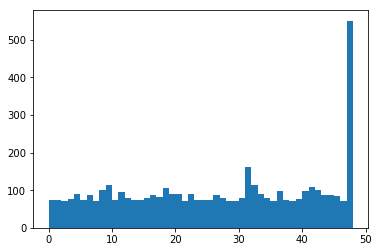

In [136]:
aa = open("Adj");
aa = aa.read();
aa = aa.split();
w, h = 4096, 100;
A_temp = [[0 for xx in range(w)] for yy in range(h)];
for i in range(0,409600):
    A_temp[i//4096][i%4096] = float(aa[i]);

dist, idx = graph.distance_scipy_spatial(A_temp, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

assert A.shape == (d, d)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
# plt.spy(A, markersize=1, color='black');
cn = np.arange(50);
for i in range(0,50):
    cn[i] = 0;
for i in range(0,len(y_train)):
    cn[y_train[i]]+=1;
print(num);
print(cn);
bins = np.linspace(0,48,49);
plt.hist(y_train,bins);

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

In [137]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 112 nodes (12 added),|E| = 861 edges
Layer 1: M_1 = |V| = 56 nodes (3 added),|E| = 484 edges
Layer 2: M_2 = |V| = 28 nodes (1 added),|E| = 231 edges
Layer 3: M_3 = |V| = 14 nodes (0 added),|E| = 83 edges


We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

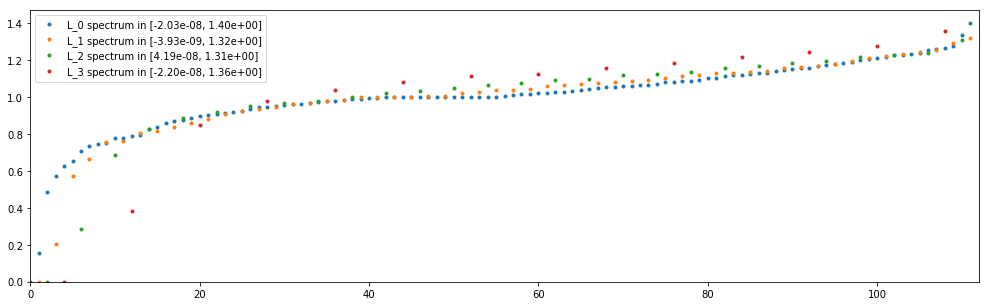

In [138]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [139]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 100
params['eval_frequency'] = 200
# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
#assert C == np.unique(y).size
# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [140]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 112
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 112 * 32 / 4 = 896
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 28 * 64 / 2 = 896
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 896 * 512 = 458752
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 50
    weights: M_3 * M_4 = 512 * 50 = 25600
    biases: M_4 = 50
step 200 / 1853 (epoch 4.32 / 40):
  learning_rate = 8.15e-04, loss_average = 4.43e+00


/users/neeraj.b/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 10.93 (73 / 668), f1 (weighted): 3.98, loss: 4.66e+00
  time: 7s (wall 11s)
step 400 / 1853 (epoch 8.63 / 40):
  learning_rate = 6.63e-04, loss_average = 3.94e+00
  validation accuracy: 28.29 (189 / 668), f1 (weighted): 22.17, loss: 4.21e+00
  time: 13s (wall 22s)
step 600 / 1853 (epoch 12.95 / 40):
  learning_rate = 5.40e-04, loss_average = 3.49e+00
  validation accuracy: 37.28 (249 / 668), f1 (weighted): 31.66, loss: 3.81e+00
  time: 19s (wall 33s)
step 800 / 1853 (epoch 17.27 / 40):
  learning_rate = 4.18e-04, loss_average = 3.30e+00
  validation accuracy: 42.51 (284 / 668), f1 (weighted): 37.93, loss: 3.60e+00
  time: 26s (wall 44s)
step 1000 / 1853 (epoch 21.58 / 40):
  learning_rate = 3.41e-04, loss_average = 3.11e+00
  validation accuracy: 43.71 (292 / 668), f1 (weighted): 39.72, loss: 3.51e+00
  time: 32s (wall 54s)
step 1200 / 1853 (epoch 25.90 / 40):
  learning_rate = 2.77e-04, loss_average = 2.93e+00
  validation accuracy: 44.01 (294 / 668), f1 (weight

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

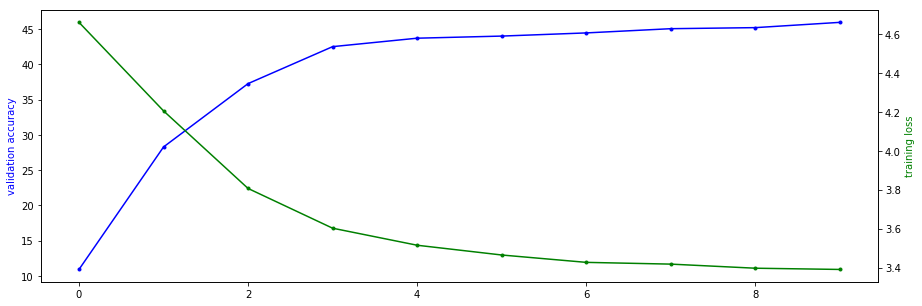

In [141]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [142]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 56.73 ms


In [143]:
res = model.evaluate(X_test, y_test)
print(res[0])

accuracy: 44.20 (598 / 1353), f1 (weighted): 41.44, loss: 3.36e+00
time: 1s (wall 2s)


/users/neeraj.b/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
